In [1]:
import numpy
import librosa
import matplotlib.pyplot as plt

In [2]:
TARGET_SR = 22050
BINS_PER_SEMITONE = 3
N_OCTAVES = 6
FMIN = 32.7
BINS_PER_OCTAVE = 12 * BINS_PER_SEMITONE
N_BINS = N_OCTAVES * BINS_PER_OCTAVE
HOP_LENGTH = 512  # 23 ms hop
N_TIME_FRAMES = 50  # 1.16 seconds

CQT_FREQUENCIES = librosa.cqt_frequencies(n_bins=N_BINS, fmin=FMIN, bins_per_octave=BINS_PER_OCTAVE)


In [3]:
def load_audio(audio_path):
    y, _ = librosa.load(audio_path, sr=TARGET_SR, mono=True)
    return y

In [4]:
y = load_audio('trainData/01-D_AMairena.wav')

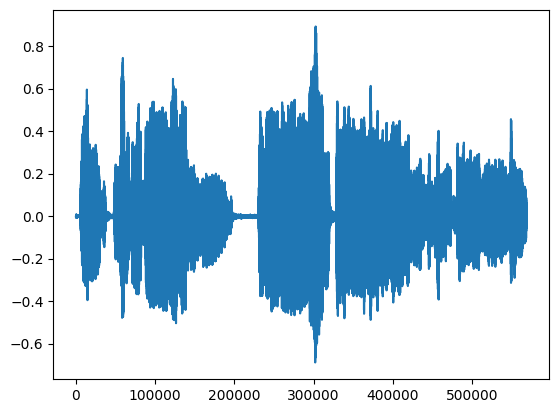

In [5]:
plt.plot(y)

In [6]:
import math

def load_f0_file(path):
    data = np.loadtxt(path)
    times = data[:, 0]      # seconds
    f0_hz = data[:, 2]      # corrected F0 in Hz (0 => unvoiced)
    return times, f0_hz


def f0_to_salience_time_major(
    f0_times,
    f0_hz,
    freqs_hz,
    frame_times,
    sigma_cents=25.0,
):
    """
    Returns salience with shape (T, F):
        T = number of frames
        F = number of frequency bins
    """

    F = len(freqs_hz)
    T = len(frame_times)
    salience_FT = np.zeros((F, T), dtype=np.float32)

    log2_freqs = np.log2(freqs_hz)

    # interpolate F0 onto the HCQT/CQT frame time grid
    f0_interp = np.interp(frame_times, f0_times, f0_hz, left=0.0, right=0.0)

    for t_idx, f0 in enumerate(f0_interp):
        if f0 <= 0:
            # unvoiced → leave as zeros
            continue

        log2_f0 = math.log2(f0)
        diff_cents = 1200.0 * (log2_freqs - log2_f0)

        sal_t = np.exp(-0.5 * (diff_cents / sigma_cents) ** 2)
        m = sal_t.max()
        if m > 0:
            sal_t /= m

        salience_FT[:, t_idx] = sal_t

    # transpose to (T, F) for your generator
    salience_TF = salience_FT.T
    return salience_TF


In [7]:
import librosa
import numpy as np

def compute_hcqt(y, sr, harmonics=[0.5,1,2,3,4],
                 bins_per_octave=60, n_octaves=6,
                 hop_length=512):

    n_bins = bins_per_octave * n_octaves
    fmin = librosa.note_to_hz("C2")

    freqs = librosa.cqt_frequencies(
        n_bins=n_bins,
        fmin=fmin,
        bins_per_octave=bins_per_octave,
    )

    hcqt_list = []

    for h in harmonics:
        # correct pitch shift call
        y_h = librosa.effects.pitch_shift(
            y, sr=sr, n_steps=12*np.log2(h)
        )

        C = librosa.cqt(
            y_h, sr=sr, hop_length=hop_length,
            bins_per_octave=bins_per_octave,
            n_bins=n_bins,
        )
        Cmag = np.abs(C)  # (F, T)
        Cmag = Cmag.T     # (T, F)

        hcqt_list.append(Cmag)

    # final shape (H, T, F)
    hcqt = np.stack(hcqt_list, axis=0)
    return hcqt, freqs


def get_cqt_times(n_bins):
    return librosa.frames_to_time(np.arange(n_bins), sr=TARGET_SR, hop_length=HOP_LENGTH)

In [10]:
audio_path = "trainData/01-D_AMairena.wav"
f0_path    = "trainData/01-D_AMairena.f0.Corrected.txt"

# 1. Load audio (or however you did it for HCQT)
audio, sr = librosa.load(audio_path, sr=None)


    


In [9]:
def iter_samples_for_track(hcqt, target_salience, n_time_frames):
    """
    hcqt: (C, T, F)
    target_salience: (T, F)
    yields (sample, label, t_idx)
      sample: (C, n_time_frames, F)
      label:  (n_time_frames, F, 1)
    """
    
    #GETTING slices for samples 
    T = hcqt.shape[1]
    for t_idx in range(0, T - n_time_frames + 1):
        sample = hcqt[:, t_idx : t_idx + n_time_frames, :]
        label = target_salience[t_idx : t_idx + n_time_frames, :, np.newaxis]
        yield sample, label, t_idx
        


        
        
hcqt,freqs_hz = compute_hcqt(audio, TARGET_SR)
n_times = hcqt.shape[1]
times = get_cqt_times(n_times)    
    
f0_times, f0_hz = load_f0_file(f0_path)
target_salience = f0_to_salience_time_major(
f0_times,
f0_hz,
freqs_hz,
times,
sigma_cents=25.0,)
    
print("hcqt shape:", hcqt.shape)               # (C, T, F)
print("target_salience shape:", target_salience.shape)  # (T, F)    

# we can get each sample now
for sample, label, t0 in iter_samples_for_track(hcqt, target_salience, N_TIME_FRAMES):
    print("sample shape:", sample.shape)  # (C, N_TIME_FRAMES, F)
    print("label shape:", label.shape)    # (N_TIME_FRAMES, F, 1)
    print("t0:", t0)
    break


hcqt shape: (5, 2224, 360)
target_salience shape: (2224, 360)
sample shape: (5, 50, 360)
label shape: (50, 360, 1)
t0: 0


Plotting window starting at: 0


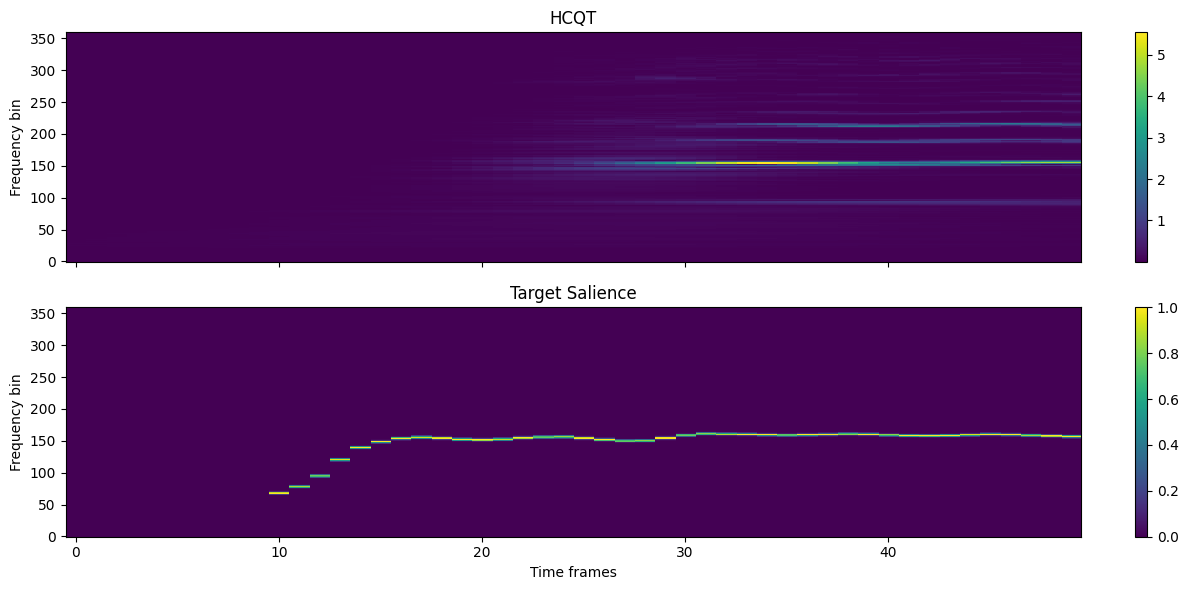

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_and_label(sample, label, freqs_hz, sr=None, hop_length=None):
    """
    sample: (C, T, F)
    label:  (T, F, 1)
    """

    C, T, F = sample.shape
    label = label[:, :, 0]  # remove last dim → (T, F)

    # Pick harmonic 0 (fundamental layer)
    hcqt_slice = sample[0].T        # → (F, T)
    salience_slice = label.T        # → (F, T)

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    # 1) Plot HCQT magnitude
    im1 = ax[0].imshow(
        hcqt_slice,
        aspect='auto',
        origin='lower',
        interpolation='nearest'
    )
    ax[0].set_title("HCQT")
    ax[0].set_ylabel("Frequency bin")
    fig.colorbar(im1, ax=ax[0], fraction=0.015)

    # 2) Plot target salience
    im2 = ax[1].imshow(
        salience_slice,
        aspect='auto',
        origin='lower',
        interpolation='nearest'
    )
    ax[1].set_title("Target Salience")
    ax[1].set_xlabel("Time frames")
    ax[1].set_ylabel("Frequency bin")
    fig.colorbar(im2, ax=ax[1], fraction=0.015)

    plt.tight_layout()
    plt.show()

for sample, label, t0 in iter_samples_for_track(hcqt, target_salience, N_TIME_FRAMES):
    print("Plotting window starting at:", t0)
    plot_sample_and_label(sample, label, freqs_hz)
    break

## Toy Dataset

In [13]:
NUM_FAKE_SAMPLES = 10 

for sample, label, t0 in iter_samples_for_track(hcqt, target_salience, N_TIME_FRAMES):
    real_sample = sample        # (C, T, F)
    real_label = label          # (T, F, 1)
    break

fake_samples = [real_sample for _ in range(NUM_FAKE_SAMPLES)]
fake_labels  = [real_label  for _ in range(NUM_FAKE_SAMPLES)]

from torch.utils.data import Dataset, DataLoader
import torch

class ToyPitchData(Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X = torch.tensor(self.samples[idx], dtype=torch.float32)   # (C, T, F)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)    # (T, F, 1)
        return X, y


## Defining The Model

In [15]:
import torch
from torch import nn

class PitchSalience(nn.Module):
    def __init__(self):
        super(PitchSalience, self).__init__()
        self.conv1 = nn.Conv2d(5, 16, (3, 3), padding="same")
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, (3, 3), padding="same")
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 1, (3, 3), padding="same")
        self.relu = nn.ReLU()

    def forward(self, x):
        # input is (batch, channels, time, freq)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)  # (batch, 1, time, freq)

        x = torch.transpose(x, 1, 2)  # (batch, time, 1, freq)
        x = torch.transpose(x, 2, 3)  # (batch, time, freq, 1)
        # no sigmoid at the end here, because we are using BCEWithLogitsLoss
        return x


## DataLoader



In [16]:
from torch.utils.data import Dataset, DataLoader
# Split toy data into "train" and "validation"

split = int(0.8 * NUM_FAKE_SAMPLES)
train_samples = fake_samples[:split]
train_labels  = fake_labels[:split]
val_samples   = fake_samples[split:]
val_labels    = fake_labels[split:]

train_dataset = ToyPitchData(train_samples, train_labels)
val_dataset   = ToyPitchData(val_samples, val_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


# Training 
model = PitchSalience().to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.ones([1]) * 10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Using device: cpu


In [17]:
print(model)

PitchSalience(
  (conv1): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu): ReLU()
)


In [18]:
for epoch in range(1):
    print(f"Epoch {epoch+1}")
    model.train()
    for batch_idx, (X, y) in enumerate(train_loader):
        X = X.to(device)                # (B, C, T, F)
        y = y.to(device)                # (B, T, F, 1)

        pred = model(X)                 # (B, T, F, 1)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 2 == 0:
            print(f"  Batch {batch_idx}, loss = {loss.item():.4f}")

    # simple validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
    val_loss /= max(1, len(val_loader))
    print(f"  Validation loss: {val_loss:.4f}")


Epoch 1
  Batch 0, loss = 0.7418
  Validation loss: 0.7065


In [19]:
import matplotlib.pyplot as plt
import torch

def visualize(model, hcqt, salience):
    """
    Visualize model input, target salience, and prediction.
    hcqt:    torch.Tensor (B, C, T, F)
    salience torch.Tensor (B, T, F, 1)
    """
    model.eval()
    with torch.no_grad():
        predicted_salience = model(hcqt)

    fig = plt.figure(figsize=(12, 12))
    n_examples = min(3, hcqt.shape[0])  # show up to 3 examples

    for i in range(n_examples):

        # -------------------------
        # 1. Plot the HCQT (harmonic 1 → channel index 1)
        # -------------------------
        plt.subplot(n_examples, 3, 1 + 3*i)
        plt.imshow(hcqt[i, 1].cpu().T, origin="lower", cmap="magma", aspect='auto')
        plt.colorbar()
        plt.title("HCQT (h=1)")
        plt.axis("tight")

        # -------------------------
        # 2. Plot the TARGET salience
        # -------------------------
        plt.subplot(n_examples, 3, 2 + 3*i)
        plt.imshow(salience[i, :, :, 0].cpu().T, origin="lower", cmap="magma", aspect='auto')
        plt.colorbar()
        plt.title("Target Salience")
        plt.axis("tight")

        # -------------------------
        # 3. Plot the MODEL prediction
        # -------------------------
        plt.subplot(n_examples, 3, 3 + 3*i)
        plt.imshow(torch.sigmoid(predicted_salience[i, :, :, 0]).cpu().T,
                   origin="lower", cmap="magma", aspect='auto')
        plt.colorbar()
        plt.title("Predicted Salience")
        plt.axis("tight")

    plt.tight_layout()
    return fig


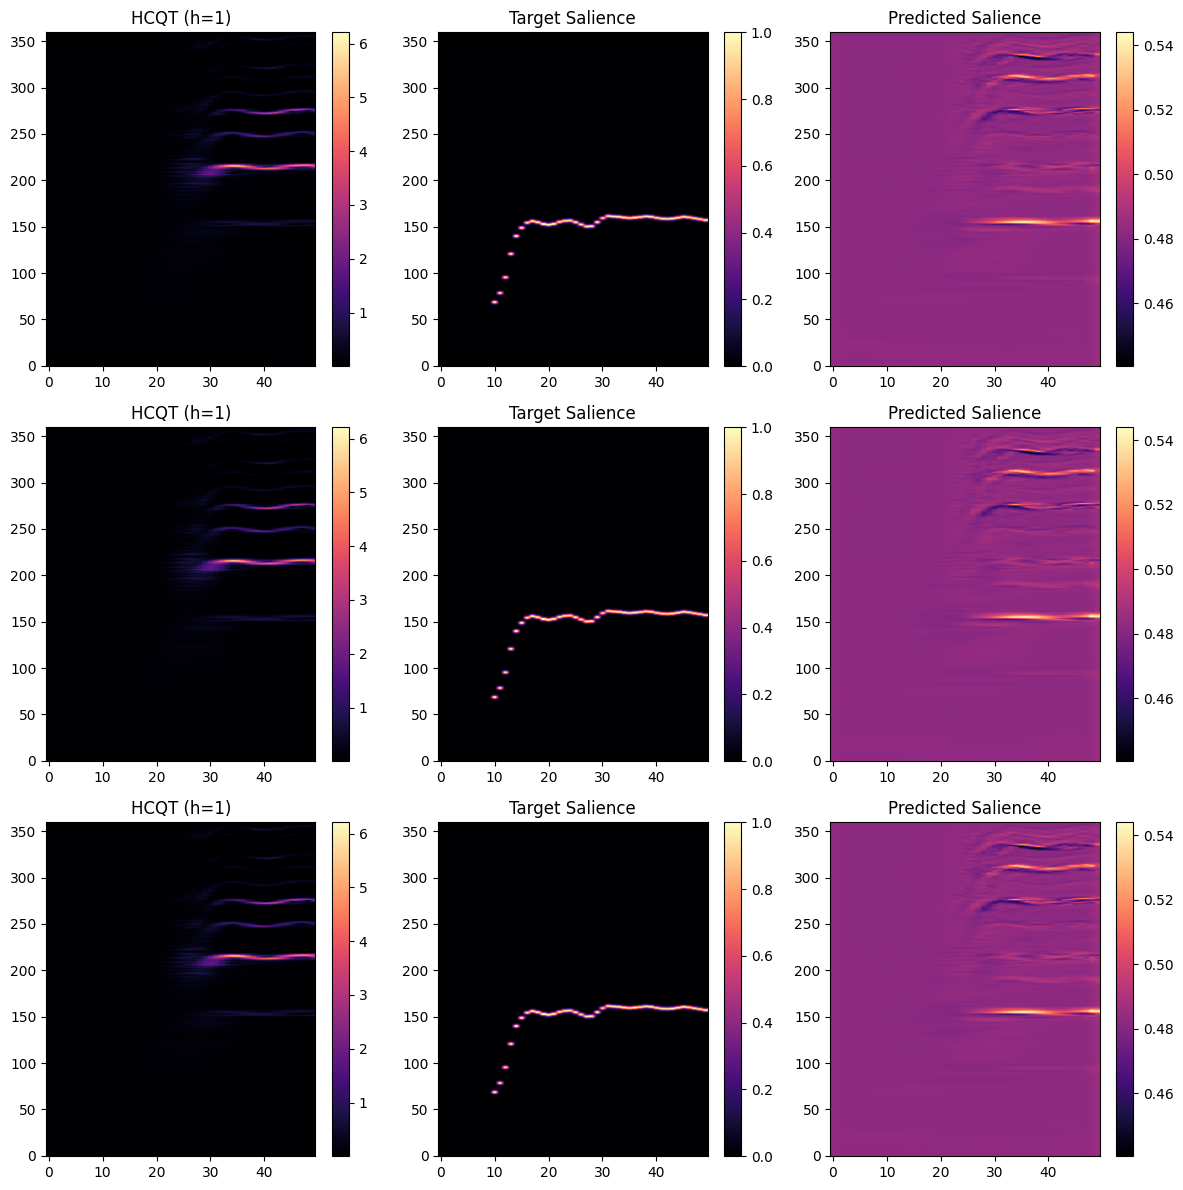

In [20]:
X_batch, y_batch = next(iter(train_loader))

fig = visualize(model, X_batch, y_batch)
plt.show()
